# Low Level Neural Network Libraries

## Table Of Contents

* Tensorflow Low Level Api

## Introduction

Now that we've gone through how to build a neural network from scratch, it's time to learn how to use frameworks to program neural networks, sort of from scratch, but using some of the helpful pieces to make our lives a little easier, while still allowing for the flexibility of going deep into the code.

We are going to start with Tensorflow since it was one of the first successful neural network frameworks out there.  We'll see how to implement layers and write our first working network.  

There are two major components to a neural network in tensorflow:

* The model high level architecture
* The individual layers

This should seem familiar from the last section, this is because it's simply the right way to think about neural network design.  The major difference is now we'll need to implement less.  Let's look at an example of linear regression using tensorflow:

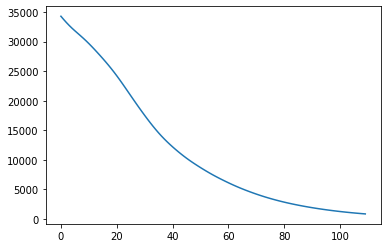

In [15]:
from tensorflow.keras import Model
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, input_dim, output_size, name=None, final=False):
        super().__init__(name=name)
        self.final = final
        init_weights = tf.random.normal([input_dim, output_size])
        self.w = tf.Variable(
            init_weights, name='w'
        )
        self.b = tf.Variable(
            tf.zeros([output_size]), name='b'
        )
        
    def __call__(self, x):
        result = tf.matmul(x, self.w) + self.b
        if self.final:
            return result[:,0]
        return result

        
class NeuralNet(Model):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer = Dense(X_in, X_out, final=True)
        self.optimizer = optimizer
        
    def call(self, x):
        return self.layer(x)

    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.call(x)
            loss = mse(pred, y)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

def mse(prediction, truth):
    prediction = tf.cast(prediction, tf.float64)
    truth = tf.cast(truth, tf.float64)
    return tf.metrics.MSE(prediction, truth)


if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    learning_rate = 0.9
    optimizer = tf.optimizers.Adam(learning_rate)
    nn = NeuralNet(X_train.shape[1], 1, optimizer)
    num_steps = 110
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = mse(pred, y_test)
        losses.append(loss)
    plt.plot(losses)


As this simple example shows, we are using the neural network framework to do linear regression.  If it's unclear where that's happening - recall that each of the individual layers are models themselves.  Here the linear regression 'model' is implemented here:

```python
def __call__(self, x):
    result = tf.matmul(x, self.w) + self.b
    if self.final:
        return result[:,0]
    return result
```

As you can tell we are doing the standard thing, as seen from previous chapters.  The only real difference is we are using tenorflow's matrix multiplication which is the same (more or less) as numpy.dot.  This is the first advantage of using a library like tensorflow, a lot of the heavy lifting is already done for us.  Not only do we get matrix multiplication for free, we also get automatic differentiation, so we don't need to calculate any derivatives.  

As a result of doing our linear regression as well as optimizing subject to our loss, we actually get something 'stronger' than straight linear regression.  Specifically, we do our linear regression at each forward pass and then we update our weights subject to the gradient of our loss, meaning we are more or less fine-tuning our weights on every back pass and then doing linear regression on our forward pass.  By constantly fine tuning our weights and then carrying out linear regression, we end up with an optimized form of linear regression.  Which in a sense is the power of neural networks in the first place.

There is actually a second optimization that we get for 'free' with tensorflow - that is the ADAM optimizer, which is an adaptive version of the standard stochastic gradient descent where the learning rate is adjusted throughout the learning process subject to momentum - when the loss is large, the learning rate adjusts alot, and when the loss is small, the learning rate adjusts a little.  In this way, we are optimizing the learning rate as we train.

These two innovations - optimizing the weight initialization and optimizing the learning rate lead to an efficient optimization process, which is at the heart of why neural networks perform so well - they are adaptive to their own initial bad guesses and correct for them quickly where they matter - with the weight update and the loss function.  These two structural pieces of training any model contribute the most to how fast they will converge.  Or whether convergence happens at all.  And we get them, more or less for free with any neural network framework.